In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import scipy
from statsmodels.stats.weightstats import _zconfint_generic, _tconfint_generic
from sklearn.preprocessing import StandardScaler
%pylab inline

import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


In [2]:
def print_to_file(value, name):
    print(name, value)
    with open(name, "w") as file:
        file.write(str(value))

# Анализ данных в задаче кредитного скоринга

Для выполнения этого задания вам понадобятся данные о кредитных историях клиентов одного из банков. Поля в предоставляемых данных имеют следующий смысл:

- LIMIT_BAL: размер кредитного лимита (в том числе и на семью клиента)
- SEX: пол клиента (1 = мужской, 2 = женский )
- EDUCATION: образование (0 = доктор, 1 = магистр; 2 = бакалавр; 3 = выпускник школы; 4 = начальное образование; 5= прочее; 6 = нет данных ).
- MARRIAGE: (0 = отказываюсь отвечать; 1 = замужем/женат; 2 = холост; 3 = нет данных).
- AGE: возраст в годах
- PAY_0 - PAY_6 : История прошлых платежей по кредиту. PAY_6 - платеж в апреле, ... Pay_0 - платеж в сентябре. Платеж = (0 = исправный платеж, 1=задержка в один месяц, 2=задержка в 2 месяца ...)
- BILL_AMT1 - BILL_AMT6: задолженность, BILL_AMT6 - на апрель, BILL_AMT1 - на сентябрь
- PAY_AMT1 - PAY_AMT6: сумма уплаченная в PAY_AMT6 - апреле, ..., PAY_AMT1 - сентябре
- default - индикатор невозврата денежных средств

In [3]:
df = pd.read_csv('credit_card_default_analysis.csv')
df.head(5)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,0,0,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
ID           30000 non-null int64
LIMIT_BAL    30000 non-null int64
SEX          30000 non-null int64
EDUCATION    30000 non-null int64
MARRIAGE     30000 non-null int64
AGE          30000 non-null int64
PAY_0        30000 non-null int64
PAY_2        30000 non-null int64
PAY_3        30000 non-null int64
PAY_4        30000 non-null int64
PAY_5        30000 non-null int64
PAY_6        30000 non-null int64
BILL_AMT1    30000 non-null int64
BILL_AMT2    30000 non-null int64
BILL_AMT3    30000 non-null int64
BILL_AMT4    30000 non-null int64
BILL_AMT5    30000 non-null int64
BILL_AMT6    30000 non-null int64
PAY_AMT1     30000 non-null int64
PAY_AMT2     30000 non-null int64
PAY_AMT3     30000 non-null int64
PAY_AMT4     30000 non-null int64
PAY_AMT5     30000 non-null int64
PAY_AMT6     30000 non-null int64
default      30000 non-null int64
dtypes: int64(25)
memory usage: 5.7 MB


## Размер кредитного лимита (LIMIT_BAL)
Размер кредитного лимита (LIMIT_BAL). В двух группах, тех людей, кто вернул кредит (default = 0) и тех, кто его не вернул (default = 1) проверьте гипотезы: 
- a) о равенстве медианных значений кредитного лимита с помощью подходящей интервальной оценки 
- b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних. 

Значимы ли полученные результаты с практической точки зрения ?

In [5]:
df_return = df[df.default == 0]
df_not_return = df[df.default == 1]

In [6]:
def plot_hists(column):
    pylab.figure(figsize(12, 5))
    pylab.subplot(1,2,1)
    pylab.hist(df_return[column], label = 'return')
    pylab.legend()

    pylab.subplot(1,2,2)
    pylab.hist(df_not_return[column], label = 'not_return')
    pylab.legend()

    pylab.show()

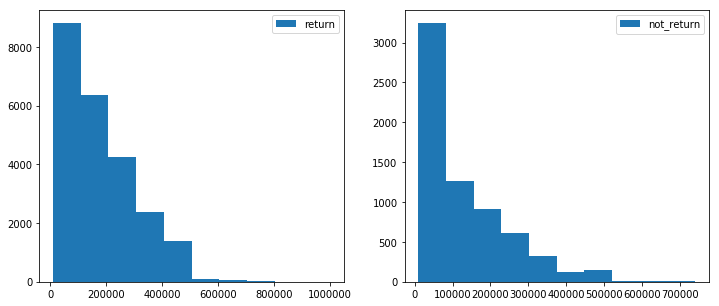

In [7]:
plot_hists('LIMIT_BAL')

### bootstrap - интервальная оценка

In [8]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [9]:
np.random.seed(0)

return_limit_bal = df_return.LIMIT_BAL.values
not_return_limit_bal = df_not_return.LIMIT_BAL.values

return_limit_bal_median_scores = list(map(np.median, get_bootstrap_samples(return_limit_bal, 1000)))
not_return_limit_bal_median_scores = list(map(np.median, get_bootstrap_samples(not_return_limit_bal, 1000)))

print("95% confidence interval for the return:",  stat_intervals(return_limit_bal_median_scores, 0.05))
print("95% confidence interval for the not return:",  stat_intervals(not_return_limit_bal_median_scores, 0.05))

95% confidence interval for the return: [150000. 150000.]
95% confidence interval for the not return: [80000. 90000.]


Интервальная оценка с помощью бутстрапа показала, что интервалы не пересекаются - значит медианы размера кредитного лимита у этих двух выборок статистически отличаются.

### Критерий Манна-Уитни

$H_0\colon F_{X_1}(x) = F_{X_2}(x)$

$H_1\colon F_{X_1}(x) = F_{X_2}(x + \Delta), \Delta\neq 0$

In [10]:
stats.mannwhitneyu(df_return.LIMIT_BAL, df_not_return.LIMIT_BAL)

MannwhitneyuResult(statistic=59257217.5, pvalue=6.127742909111652e-190)

Нулевая гипотеза о равенстве размера кредитного лимита отвергается в пользу альтернативной гипотезы при проверке с помощью критерия Манна-Уитни. Получается, что медианы размера кредитного лимита этих двух выборок статистически отличаются.
### Перестановочный критерий

In [11]:
def permutation_t_stat_ind(sample1, sample2):
    return np.mean(sample1) - np.mean(sample2)
def get_random_combinations(n1, n2, max_combinations):
    index = list(range(n1 + n2))
    indices = set([tuple(index)])
    for i in range(max_combinations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return [(index[:n1], index[n1:]) for index in indices]
def permutation_zero_dist_ind(sample1, sample2, max_combinations = None):
    joined_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n = len(joined_sample)
    
    if max_combinations:
        indices = get_random_combinations(n1, len(sample2), max_combinations)
    else:
        indices = [(list(index), list(filter(lambda i: i not in index, range(n)))) \
                    for index in itertools.combinations(range(n), n1)]
    
    distr = [joined_sample[list(i[0])].mean() - joined_sample[list(i[1])].mean() \
             for i in indices]
    return distr
def permutation_test(sample, mean, max_permutations = None, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_ind(sample, mean)
    
    zero_distr = permutation_zero_dist_ind(sample, mean, max_permutations)
    
    if alternative == 'two-sided':
        return sum([1. if abs(x) >= abs(t_stat) else 0. for x in zero_distr]) / len(zero_distr)
    
    if alternative == 'less':
        return sum([1. if x <= t_stat else 0. for x in zero_distr]) / len(zero_distr)

    if alternative == 'greater':
        return sum([1. if x >= t_stat else 0. for x in zero_distr]) / len(zero_distr)

In [12]:
max_pers = [100, 1000, 2000, 5000]
for max_per in max_pers:
    print("При max_permutations", max_per, 'получаем p-value',
          permutation_test(df_return.LIMIT_BAL, df_not_return.LIMIT_BAL, max_permutations = max_per))

При max_permutations 100 получаем p-value 0.01
При max_permutations 1000 получаем p-value 0.001
При max_permutations 2000 получаем p-value 0.0005
При max_permutations 5000 получаем p-value 0.0002


Нулевая гипотеза о равенстве размера кредитного лимита отвергается в пользу альтернативной гипотезы при проверке с помощью перестановочного критерия. Получается, что медианы размера кредитного лимита этих двух выборок статистически отличаются.

### О практической значимости
Методы, которые были показаны выше, показывают статистическую значимость. Практическую значимость могут определить лишь те, кто знакомы с предметной областью. Если попробовать применить на себя эту роль, то разница в 50 тысяч при средних значениях от 80 до 150 тысяч - значимое практическое отличие.

## Пол (SEX)
Пол (SEX): Проверьте гипотезу о том, что гендерный состав группы людей вернувших и не вернувших кредит отличается. Хорошо, если вы предоставите несколько различных решений этой задачи (с помощью доверительного интервала и подходящего статистического критерия)

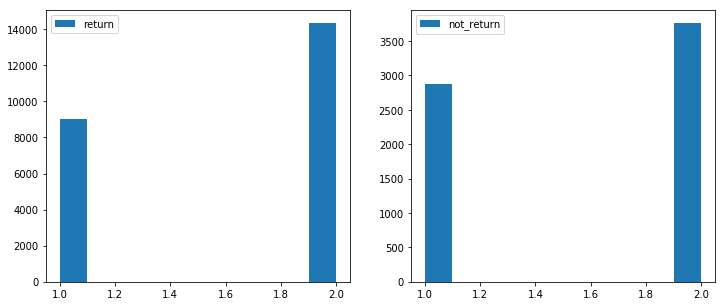

In [13]:
plot_hists('SEX')

Эти выборки отличаются друг от друга тем, что в выборке не вернувших кредит соотношение мужчин к женщинам больше, чем в выборке вернувших кредит.Можно предположить, что пол влияет на вероятность вернуть кредит - проверим это.

### Критерий Манна-Уитни

$H_0\colon F_{X_1}(x) = F_{X_2}(x)$

$H_1\colon F_{X_1}(x) = F_{X_2}(x + \Delta), \Delta\neq 0$

In [14]:
stats.mannwhitneyu(df_return.SEX, df_not_return.SEX)

MannwhitneyuResult(statistic=73871136.0, pvalue=2.2382393460630904e-12)

Нулевая гипотеза о равенстве гендерного состава отвергается в пользу альтернативной гипотезы  при проверке с помощью критерия Манна-Уитни. Получается, что медианы гендерного состава этих двух выборок статистически отличаются.

### Доверительный интервал для разности долей (независимые выборки)
   | $X_1$ | $X_2$  
  ------------- | -------------|
  1  | a | b 
  0  | c | d 
  $\sum$ | $n_1$| $n_2$
  
$$ \hat{p}_1 = \frac{a}{n_1}$$

$$ \hat{p}_2 = \frac{b}{n_2}$$


$$\text{Доверительный интервал для }p_1 - p_2\colon \;\; \hat{p}_1 - \hat{p}_2 \pm z_{1-\frac{\alpha}{2}}\sqrt{\frac{\hat{p}_1(1 - \hat{p}_1)}{n_1} + \frac{\hat{p}_2(1 - \hat{p}_2)}{n_2}}$$

In [15]:
def proportions_diff_confint_ind(sample1, sample2, alpha = 0.05):    
    z = scipy.stats.norm.ppf(1 - alpha / 2.)
    
    p1 = sample1.value_counts()[1]/ float(sample1.shape[0])
    p2 = sample2.value_counts()[1]/ float(sample2.shape[0])
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ float(sample1.shape[0]) + p2 * (1 - p2)/ float(sample2.shape[0]))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ float(sample1.shape[0]) + p2 * (1 - p2)/ float(sample2.shape[0]))
    
    return (left_boundary, right_boundary)

In [16]:
sex_not_return_interval = proportions_diff_confint_ind(df_return.SEX, df_not_return.SEX)
print("sex dif mean 95% confidence interval", sex_not_return_interval)

sex dif mean 95% confidence interval (-0.060548077974896725, -0.03363493274962867)


Ноль не входит в интервал - можно сказать, что средние двух выборок статистически отличаются.

## Образование (EDUCATION)
Образование (EDUCATION): Проверьте гипотезу о том, что образование не влияет на то, вернет ли человек долг. Предложите способ наглядного представления разницы в ожидаемых и наблюдаемых значениях количества человек вернувших и не вернувших долг. Например, составьте таблицу сопряженности "образование" на "возврат долга", где значением ячейки была бы разность между наблюдаемым и ожидаемым количеством человек. 

Как бы вы предложили модифицировать таблицу так, чтобы привести значения ячеек к одному масштабу не потеряв в интерпретируемости ? 

Наличие какого образования является наилучшим индикатором того, что человек отдаст долг ? наоборт, не отдаст долг ?

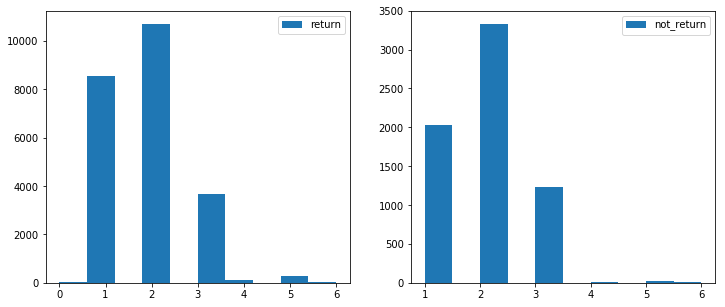

In [17]:
plot_hists('EDUCATION')

### Таблица сопряженности

In [18]:
ct_educ_def = pd.crosstab(df.EDUCATION, df.default)  
ct_educ_def.head()

default,0,1
EDUCATION,,
0,14,0
1,8549,2036
2,10700,3330
3,3680,1237
4,116,7


Можно использовать хи-квадрат, так как число наблюдений меньше пяти содержится не более чем в 20% ячеек.

In [19]:
print('p-value о важности образования в невозрате кредита ',stats.chi2_contingency(ct_educ_def)[1])

p-value о важности образования в невозрате кредита  1.2332626245415605e-32


Получается, что нулевая гипотеза о важности кредита в невозврате кредита отвергается - роль образования в возрате кредита всё же есть.

### Нормирование таблицы сопряженности
Есть несколько способ нормирования таблицы. Можно попробовать сделать нормировку от 0 до 1, иными словами сделать соотношение.

In [20]:
ct_educ_def.div(ct_educ_def.sum(axis = 1), axis='rows')

default,0,1
EDUCATION,,
0,1.000000,0.000000
1,0.807652,0.192348
2,0.762651,0.237349
3,0.748424,0.251576
4,0.943089,0.056911
5,0.935714,0.064286
6,0.843137,0.156863


При таком преобразовании стало видно следующее:
- люди с образованием 0 (доктор), 4 (начальное образование) и 5 (прочее) чаще возвращают кредиты, чем остальные
- люди с образованием 2 (бакалавр) и 3 (выпускник школы) реже возращают кредиты, чем остальные

## Семейное положение (MARRIAGE)
Семейное положение (MARRIAGE): Проверьте, как связан семейный статус с индикатором дефолта: нужно предложить меру, по которой можно измерить возможную связь этих переменных и посчитать ее значение.

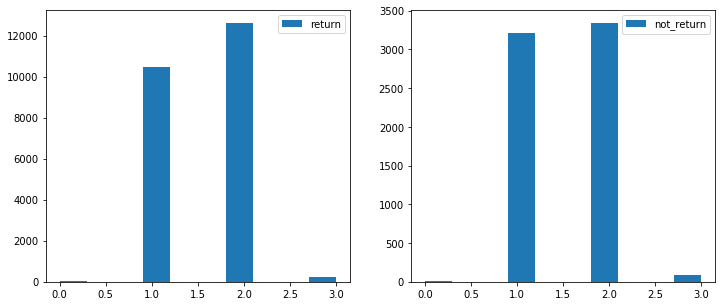

In [21]:
plot_hists('MARRIAGE')

### Таблица сопряженности

In [22]:
ct_mar_def = pd.crosstab(df.MARRIAGE, df.default)  
ct_mar_def.head()

default,0,1
MARRIAGE,,
0,49,5
1,10453,3206
2,12623,3341
3,239,84


Можно использовать хи-квадрат, так как число наблюдений меньше пяти содержится не более чем в 20% ячеек.

In [23]:
print('p-value о важности семейного положения в невозрате кредита ',stats.chi2_contingency(ct_mar_def)[1])

p-value о важности семейного положения в невозрате кредита  8.825862457577375e-08


Получается, что нулевая гипотеза о важности семейного положения в невозврате кредита отвергается - роль семейного положения в возрате кредита всё же есть.

### Нормирование таблицы сопряженности
Есть несколько способ нормирования таблицы. Можно попробовать сделать нормировку от 0 до 1, иными словами сделать соотношение.

In [24]:
ct_mar_def.div(ct_mar_def.sum(axis = 1), axis='rows')

default,0,1
MARRIAGE,,
0,0.907407,0.092593
1,0.765283,0.234717
2,0.790717,0.209283
3,0.739938,0.260062


При таком преобразовании стало видно следующее:
- люди с семейным положением 0 (отказываюсь отвечать) чаще возвращают кредиты, чем остальные
- люди с семейным положением 3 (нет данных) реже возращают кредиты, чем остальные

## Возраст (AGE)
Возраст (AGE): Относительно двух групп людей вернувших и не вернувших кредит проверьте следующие гипотезы: 
- a) о равенстве медианных значений возрастов людей 
- b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних. 

Значимы ли полученные результаты с практической точки зрения ?

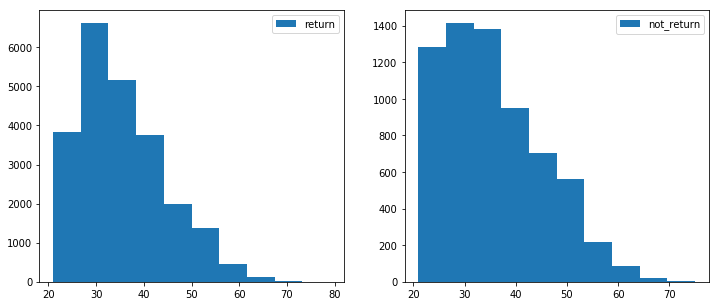

In [25]:
plot_hists('AGE')

### bootstrap - интервальная оценка

In [26]:
np.random.seed(0)

return_age = df_return.AGE.values
not_return_age = df_not_return.AGE.values

return_age_median_scores = list(map(np.median, get_bootstrap_samples(return_age, 10000)))
not_return_age_median_scores = list(map(np.median, get_bootstrap_samples(not_return_age, 10000)))

print("95% confidence interval for the return:",  stat_intervals(return_age_median_scores, 0.05))
print("95% confidence interval for the not return:",  stat_intervals(not_return_age_median_scores, 0.05))

95% confidence interval for the return: [34. 34.]
95% confidence interval for the not return: [34. 35.]


Интервалы, найденные с помощью бутстрепа, пересекаются - нельзя сказать, что средние отличаются.

### Критерий Манна-Уитни

$H_0\colon F_{X_1}(x) = F_{X_2}(x)$

$H_1\colon F_{X_1}(x) = F_{X_2}(x + \Delta), \Delta\neq 0$

In [27]:
stats.mannwhitneyu(df_return.AGE, df_not_return.AGE)

MannwhitneyuResult(statistic=76966879.5, pvalue=0.1862517717449308)

Нулевая гипотеза о равенстве гендерного состава людей не отвергается в пользу альтернативной гипотезы при проверке с помощью критерия Манна-Уитни. Получается, что медианы гендерного состава людей этих двух выборок не отличаются. 

### О практической значимости
Методы, которые были показаны выше, показывают статистическую значимость. Практическую значимость могут определить лишь те, кто знакомы с предметной областью. Если попробовать применить на себя эту роль, то разница в 1 год не играет большой роли при среднем возрасте 34-45 лет. Но если посмотреть на графики, то складывается впечатление, что молодые 20-30 лет чаще не возвращают кредит - и это с помощью критериев не увидишь. 